# Clasificador de Clientes de Empresa de Telecom
Conjunto de Datos de Kaggle [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) enfocado a programas de retención de clientes


# Cargar librerías y funciones

In [1]:
import numpy as np   
import pandas as pd 

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns     

#funciones específicas de Scikit-learn 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
#para exportar el gráfico como archivo.dot
from sklearn.tree import export_graphviz  

#para visualizar el arbol desde el formato .dot
from IPython.display import Image
from pydotplus import graph_from_dot_data


###correlacion()

In [2]:
def correlacion(dataframe, grafica=True, matrix=False):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = (25, 20))
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

### grafica_roc

In [3]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)  
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()



# 1. Lectura de datos y breve exploración

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ClasificadorClientesTelecom/master/Datos/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [5]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#Ver valores únicos de cada variable
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

## 2. Preprocesamiento


### Se eliminan las variables innecesarias


In [7]:
df = df.set_index('customerID')

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Transformación de variables y manejo de valores nulos

In [8]:
#Convertimos TotalCharges a numérica.
#Revisar para que se utiliza errors='coerce'

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') #obligo a poner valores nulos

In [9]:
#¿Cuántos valores nulos quedaron?

print(df['TotalCharges'].isnull().sum())

df[df['TotalCharges'].isnull()]

11


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


In [10]:
#Remplazamos por 0 los valores nulos 
df = df.fillna(value=0)

### Binarización de variables

In [11]:
#Revisamos las categorías y frecuencias de cada variable de tipo "objeto"

df_obj = df.select_dtypes("object")  

for col in df_obj.columns:
    print (col)
    print (df[col].value_counts(),'\n')

gender
Male      3555
Female    3488
Name: gender, dtype: int64 

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64 

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64 

PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet servi

In [12]:
yes_no_columns = [
                  'Partner','Dependents',
                  'PhoneService','PaperlessBilling',
                  'Churn'
                  ]

for i in yes_no_columns:
    df[i].replace(to_replace='Yes', 
                  value=1, inplace=True)
    df[i].replace(to_replace='No', 
                  value=0, inplace=True)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1


In [13]:
print(df.shape)
print(df.columns)

(7043, 20)
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
#Utilizamos one-hot encoding para convertir variables categoricos a binarias (con ceros y unos)
df = pd.get_dummies(df)
print(df.shape, '\n', df.columns)

(7043, 42) 
 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer

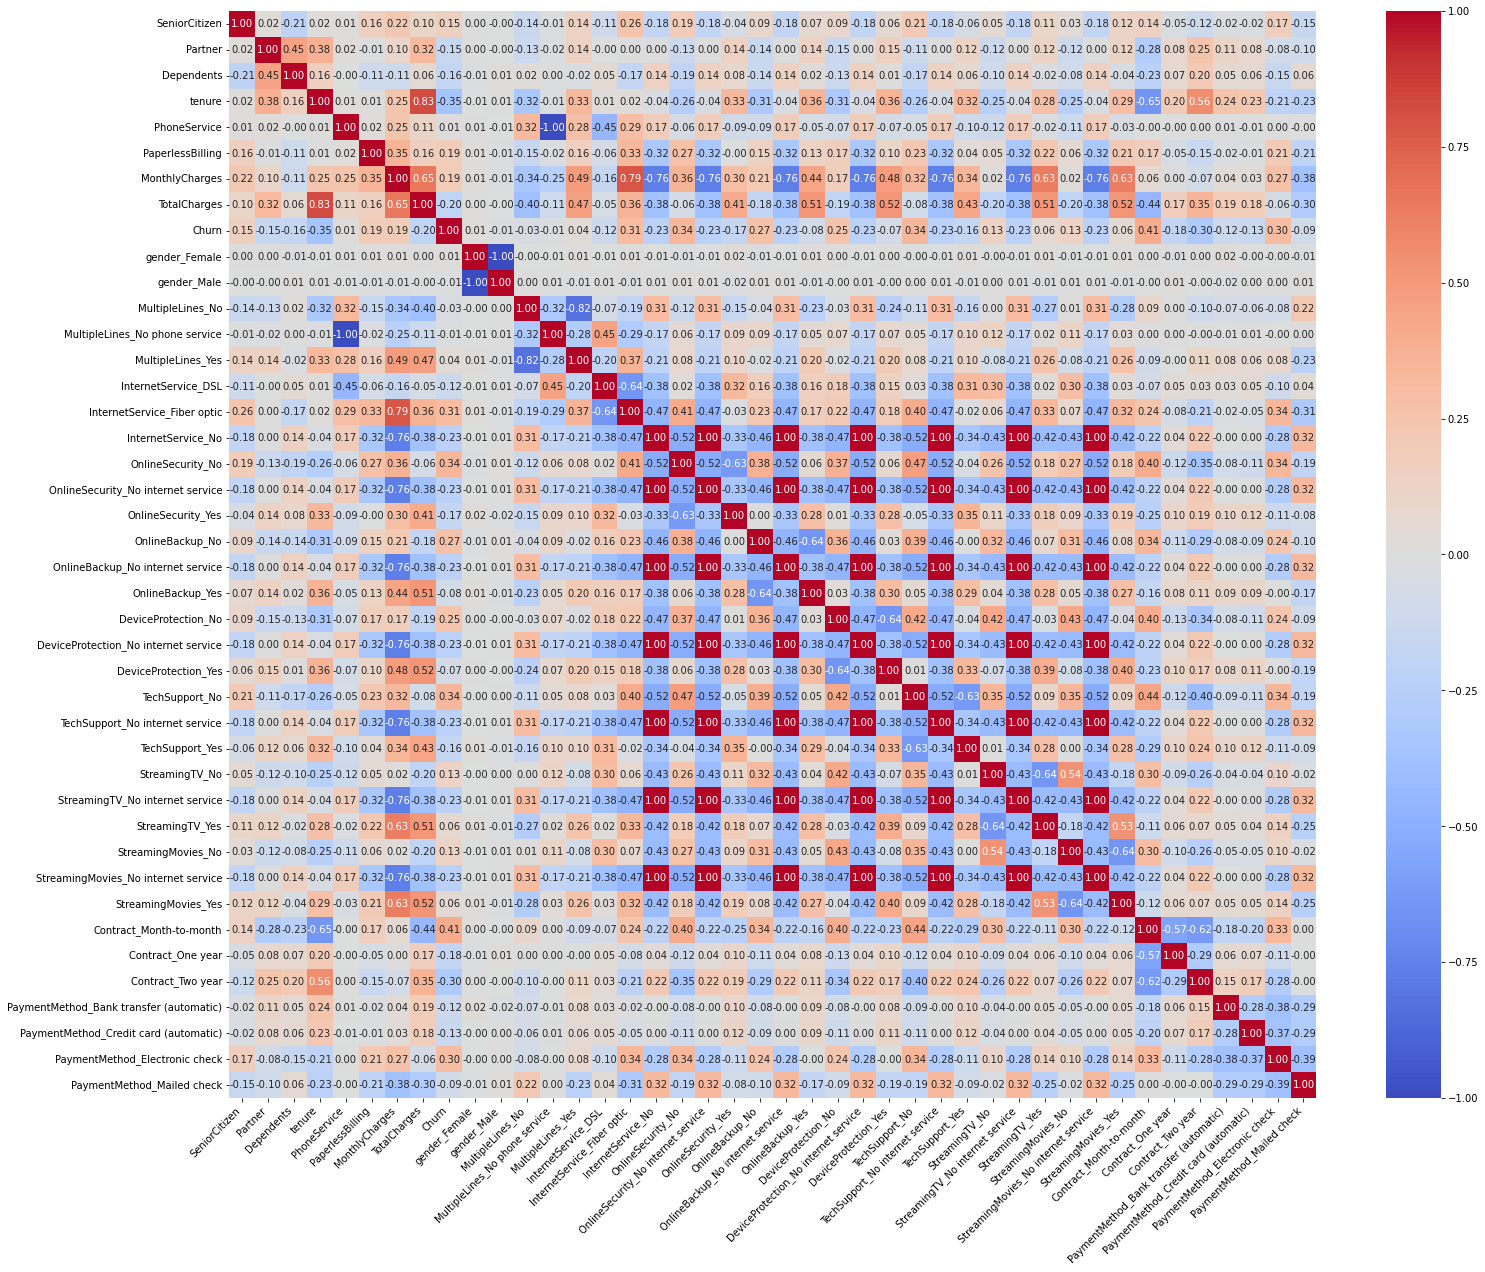

In [15]:
#Detectar variables redundantes 

corr_matrix = correlacion(df, grafica=True, matrix=True)

In [16]:
#Identificar variables redundantes 

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix),1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
borrar = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] == 1)]
borrar

['MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service']

In [17]:
#eliminar columnas en la lista borrar
df = df.drop(columns = borrar)

#renombrar columna (recordar que 0 sera Male y 1 Female)
df = df.rename(columns = {"gender_Female":"Gender"})  



In [18]:
df.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Gender',
       'gender_Male', 'MultipleLines_No', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [19]:
#Llevar columna de clase (Churn) hasta la última posición

cols = df.columns.tolist()

df = df[[c for c in df if c != 'Churn'] + ['Churn']]

print(df.shape)

df.head()

(7043, 35)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Gender,gender_Male,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,1,29.85,29.85,1,0,...,1,0,1,0,0,0,0,1,0,0
5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,0,1,...,1,0,0,1,0,0,0,0,1,0
3668-QPYBK,0,0,0,2,1,1,53.85,108.15,0,1,...,1,0,1,0,0,0,0,0,1,1
7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,0,1,...,1,0,0,1,0,1,0,0,0,0
9237-HQITU,0,0,0,2,1,1,70.70,151.65,1,0,...,1,0,1,0,0,0,0,1,0,1


In [20]:
print('Número de columnas: ', df.shape[1], '\n') 
print('Número de valores en cada columna: ')
df.nunique()

Número de columnas:  35 

Número de valores en cada columna: 


SeniorCitizen                                 2
Partner                                       2
Dependents                                    2
tenure                                       73
PhoneService                                  2
PaperlessBilling                              2
MonthlyCharges                             1585
TotalCharges                               6531
Gender                                        2
gender_Male                                   2
MultipleLines_No                              2
MultipleLines_Yes                             2
InternetService_DSL                           2
InternetService_Fiber optic                   2
InternetService_No                            2
OnlineSecurity_No                             2
OnlineSecurity_Yes                            2
OnlineBackup_No                               2
OnlineBackup_Yes                              2
DeviceProtection_No                           2
DeviceProtection_Yes                    

<AxesSubplot:>

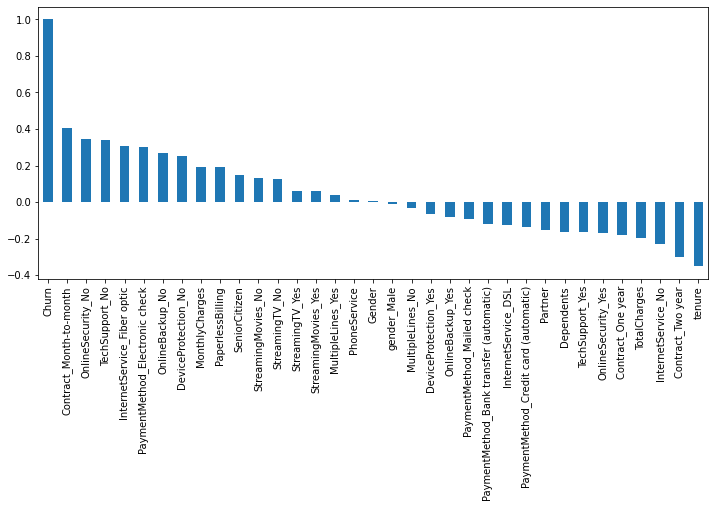

In [21]:
#Correlación de cada variable con Churn
plt.figure(figsize = (12,5))
df.corr()['Churn'].sort_values(ascending = False).plot(kind ='bar',)

# Árbol de Decisión

## Creación de subconjuntos de entrenamiento y prueba 

In [22]:
#Separar las etiquetas del conjunto de datos

Z = df['Churn']
X = df.drop('Churn', axis=1)

In [23]:
X_train, X_test, Z_train, Z_test = train_test_split(X, Z,
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=261)


In [24]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("TRAINING SET")
print("X: ", X_train.shape)
print("Z: ", Z_train.shape)
print('Clientes que cancelan:{:7.3f}%'.format(Z_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("Z: ", Z_test.shape)
print('Clientes que cancelan:{:7.3f}%'.format(Z_test.mean()*100))

TRAINING SET
X:  (4930, 34)
Z:  (4930,)
Clientes que cancelan: 26.572% 

TEST SET
X:  (2113, 34)
Z:  (2113,)
Clientes que cancelan: 26.455%


## Entrenamiento y prueba del modelo

In [25]:
profundidad = 3

#Entrenamiento del modelo
clasificador = DecisionTreeClassifier( max_depth=profundidad,
                                      criterion="entropy", 
                                      random_state=0)
clasificador.fit(X_train, Z_train)

print("La profundida del árbol es: {}".format(clasificador.get_depth()))                          

#Predicción y evaluación sobre el conjunto de entrenamiento
Z_pred_train = clasificador.predict(X_train)
precision_train = accuracy_score(Z_train, Z_pred_train)*100
print("Precisión conjunto de entrenamiento: {:4.2f}%".format(precision_train))

#Predicción y evaluación sobre el conjunto de prueba
Z_pred_test = clasificador.predict(X_test)
precision_test = accuracy_score(Z_test, Z_pred_test)*100
print("Precisión conjunto de prueba: {:4.2f}%".format(precision_test),'\n')


La profundida del árbol es: 3
Precisión conjunto de entrenamiento: 79.19%
Precisión conjunto de prueba: 78.94% 



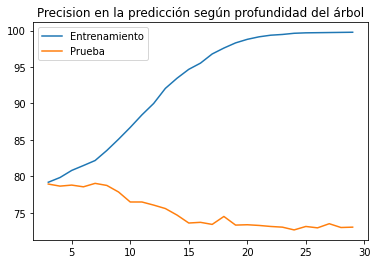

In [26]:
#Entrenamiento y prueba del modelo con distintos niveles de profunidad

clf = {}
Z_pred_train = {}
Z_pred_test = {}
precision_train={}
precision_test = {}

for p in range(3,30):
  #Entrenamiento del modelo
  clf[p] = DecisionTreeClassifier(max_depth = p,
                               criterion = "entropy", 
                               random_state = 0).fit(X_train, Z_train)                        

  #Predicción y evaluación sobre el conjunto de entrenamiento
  Z_pred_train[p] = clf[p].predict(X_train)
  precision_train[p] = accuracy_score(Z_train, Z_pred_train[p])*100

  #Predicción y evaluación sobre el conjunto de prueba
  Z_pred_test[p] = clf[p].predict(X_test)
  precision_test[p] = accuracy_score(Z_test, Z_pred_test[p])*100

precision = pd.DataFrame( {'Entrenamiento':precision_train,
                           'Prueba': precision_test})

precision.plot.line(
    title ='Precision en la predicción según profundidad del árbol')
plt.show()

## Visualización del árbol de decisión

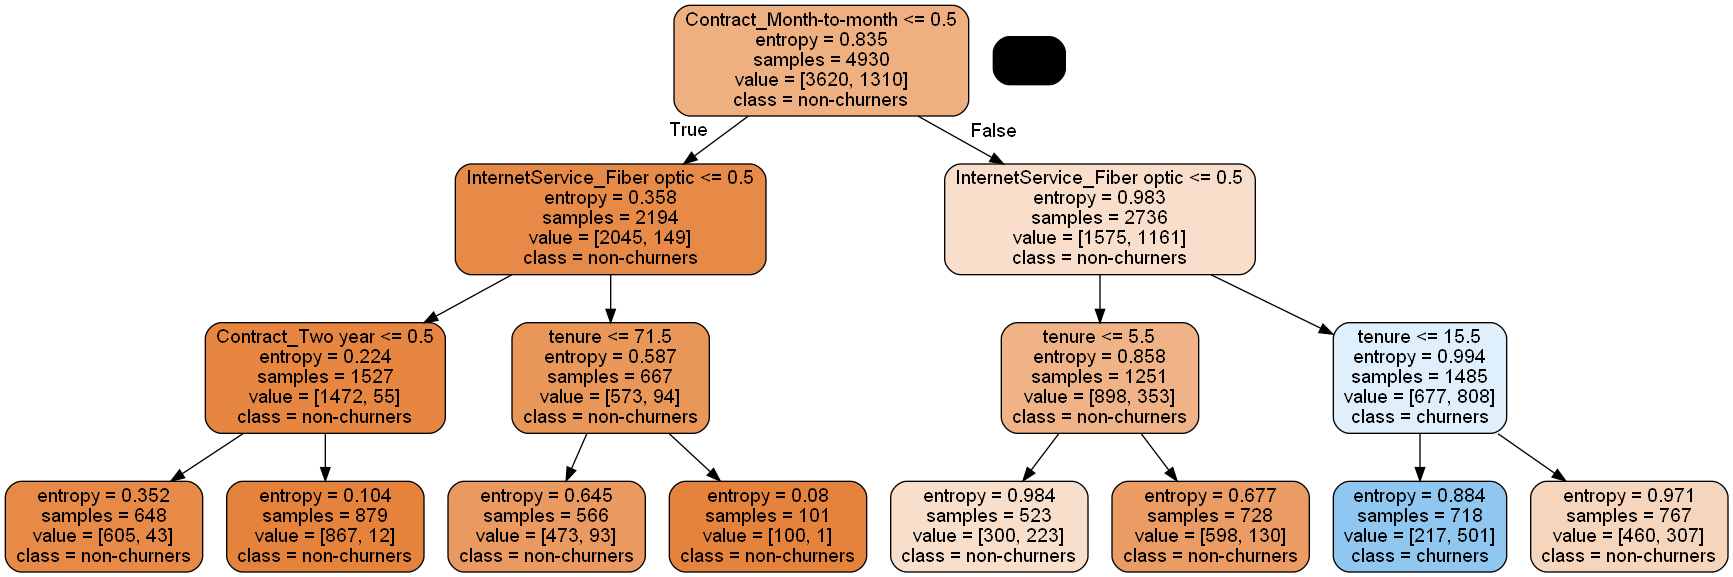

In [42]:
#Método 1 para graficar el arbol exportando el arbol como un archivo .dot

dot_data = export_graphviz(clf[3], rounded = True, 
                           filled = True, 
                           special_characters = True, 
                           feature_names = X.columns,
                           max_depth = 3,
                           class_names = ['non-churners','churners'])

graph = graph_from_dot_data(dot_data)

Image(graph.create_png( ))

In [28]:
clf[3].feature_importances_.sum()

0.9999999999999998

## Importancia de cada variable de acuerdo al modelo

<AxesSubplot:>

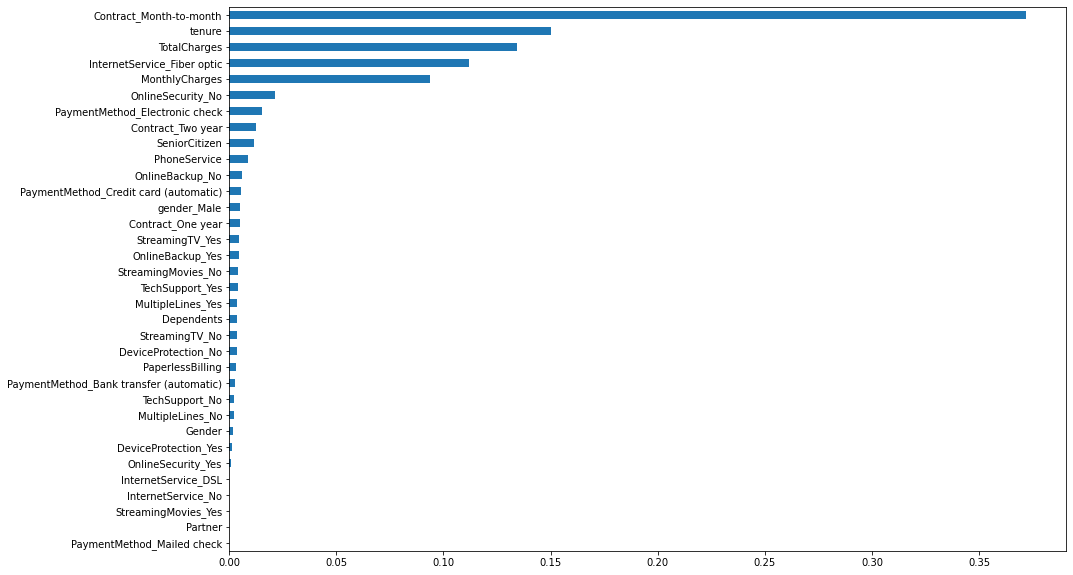

In [29]:
weights = pd.Series(clf[8].feature_importances_,
                    index=X.columns.values)

weights.sort_values().plot(kind = 'barh',figsize=(15, 10))

## Evaluació del modelo Matriz de confusión

**Matriz de confusión**

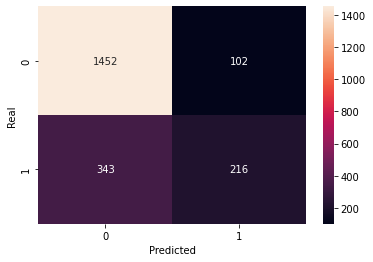

In [30]:
#Matriz de confusión

import seaborn as sns

data = {'Z_Real':  Z_test,
        'Z_Prediccion': Z_pred_test[3]
        }

df = pd.DataFrame(data, columns=['Z_Real','Z_Prediccion'])
confusion_matrix = pd.crosstab(df['Z_Real'], df['Z_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()


###**[Curva ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)**

* eje x ----  Specificity (proporción de falsos positivos (*fpr*) )
* eje y ----  Recall/Sensitivity (proporción de verdaderos positivos (*tpr*))



In [31]:
clf[3].predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
print(clf[3].predict_proba(X_test))

[[0.59973924 0.40026076]
 [0.82142857 0.17857143]
 [0.59973924 0.40026076]
 ...
 [0.98634812 0.01365188]
 [0.82142857 0.17857143]
 [0.82142857 0.17857143]]


In [33]:
umbral = 0.4 # por arriba del cual se clasificaría como clase 1
prediccion_test = np.where( clf[3].predict_proba(X_test)[:, 1] > umbral, 1, 0)
prediccion_test

array([1, 0, 1, ..., 0, 0, 0])

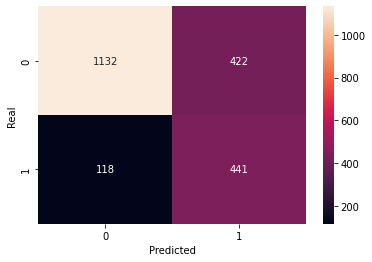

In [34]:
data = {'Z_Real':  Z_test,
        'Z_Prediccion': prediccion_test
        }

df = pd.DataFrame(data, columns=['Z_Real','Z_Prediccion'])
confusion_matrix = pd.crosstab(df['Z_Real'], df['Z_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

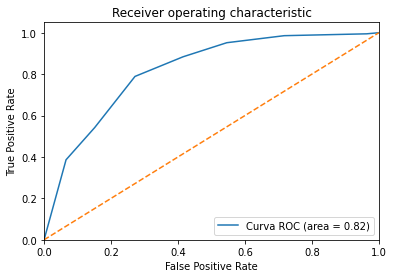

In [35]:
grafica_roc(clf[3], Z_test)


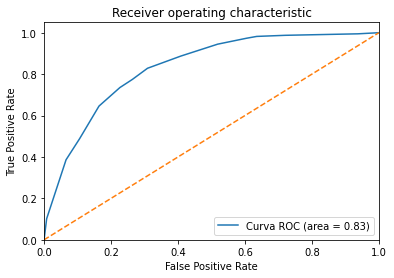

In [45]:
grafica_roc(clf[4], Z_test)

# Bosque Aleatorio

## Entrenamiento y prueba


In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf_rf = RandomForestClassifier(n_estimators=1000,  random_state =0, 
                                criterion='entropy').fit(X_train, Z_train)


Z_pred = clf_rf.predict(X_test)
print("Precisión del modelo Bosque Aleatorio en el conjunto de prueba: {:4.2f}%".format(accuracy_score(Z_test, Z_pred)*100))


Precisión del modelo Bosque Aleatorio en el conjunto de prueba: 78.42%


<AxesSubplot:>

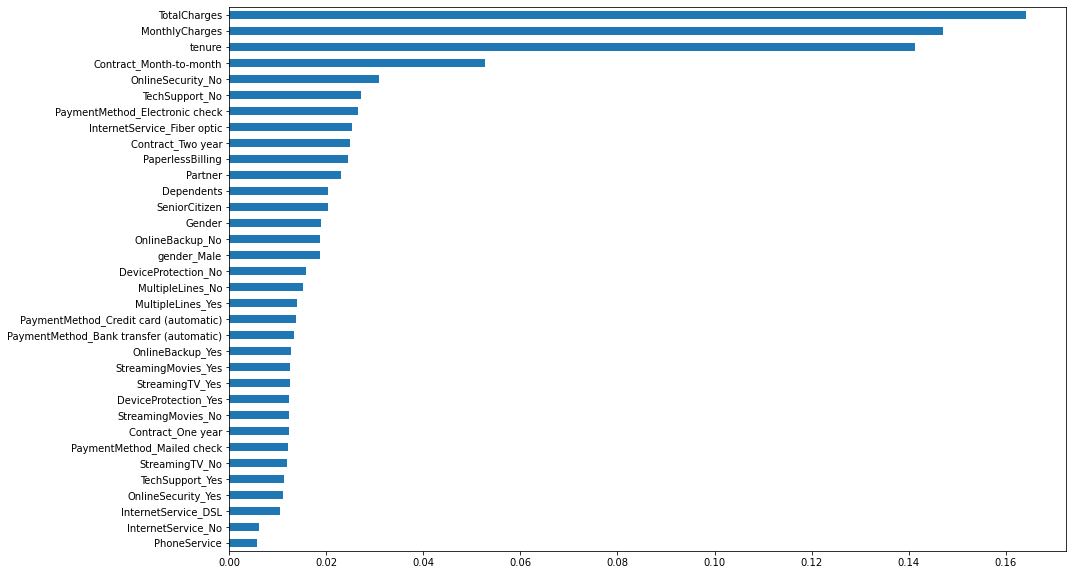

In [39]:
importances = clf_rf.feature_importances_
weights = pd.Series(importances,
                    index=X.columns.values)
weights.sort_values().plot(kind = 'barh',figsize=(15, 10))

In [40]:
weights.sum()

1.0

In [41]:
clf_rf.predict_proba(X_test)

array([[0.307, 0.693],
       [0.668, 0.332],
       [0.661, 0.339],
       ...,
       [0.885, 0.115],
       [0.866, 0.134],
       [0.575, 0.425]])